In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
# load SBML model and get parameter labels
modelfile = os.getcwd()+'/models/240226MC_FULL.sbml' # filled nan values with mean for now
r = te.loadSBMLModel(modelfile)

# get data and metadata for experiment
with open('data/230623_Kinetics_DA/simulation_ready.pkl', 'rb') as f:
    simulation_ready = pickle.load(f)
    init_concentrations = simulation_ready['init_concentrations']   
    metadata = simulation_ready['metadata']
    measurements = simulation_ready['measurements']

metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
model_species = pd.read_csv(os.getcwd()+'/src/frenda_brenda/Files/SpeciesBaseMechanisms.csv')

# get all the parameters that can vary during the fitting
kinetics_labels = [p for p in r.getGlobalParameterIds() if np.any([k in p for k in ['Km','Kcat','Ki']])]
Gi_labels = [p for p in r.getGlobalParameterIds() if 'Gi' in p ]
metabolites_labels = [model_species.loc[model_species['Label'] == s, 'Relative'].values[0] for s in metabolites] #[s for s in r.getFloatingSpeciesIds() if 'EC' not in s]

parameter_labels = kinetics_labels + Gi_labels + metabolites_labels # + list(metabolites_labels)
parameter_labels.append('rel0') # what are good bounds for this?

# make upper and lower bounds
upper = np.array([r[i]*10 for i in kinetics_labels] + [1 for _ in Gi_labels] + [10 for _ in metabolites_labels] + [10])
lower = np.array([r[i]/10 for i in kinetics_labels] + [1/100 for _ in Gi_labels] + [1/10 for _ in metabolites_labels] + [1/10])
p_initial = np.array([r[i] for i in kinetics_labels] + [0.5 for _ in Gi_labels] + [1 for _ in metabolites_labels] + [1])

# define variables that don't change during fitting, but could be different across samples
# (dilution factor, biosynthesis metabolites, which enzymes are present)
variables = {}
for s in metadata['sample_labels']:
    variables[s] = {'dilution_factor':1/metadata['dilution_factor'][s]}
    variables[s] = {**variables[s] , **{p:1 for p in r.getGlobalParameterIds() if 'p_EC' in p}}
    variables[s] = {**variables[s] , **init_concentrations[s]*1000}

In [3]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
myprob = SBMLGlobalFit_Multi_Fly(
    model = modelfile, 
    data = measurements, 
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=metadata,
    variables=variables,
    scale=True)

In [4]:
myprob._setup_rr()

In [5]:
with open('checkpoint_t.dat', 'rb') as file:
    pops = pickle.load(file)

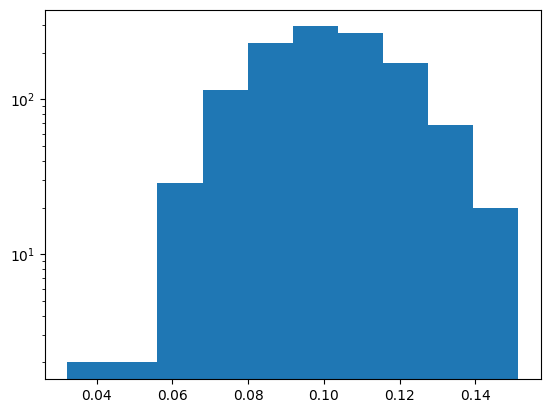

In [48]:
plt.hist(np.array(list(map(myprob._unscale,pops[0].get_x())))[:,-500])
plt.yscale('log')

In [6]:
total_nodes=5
init_std=0.17
xs = (np.expand_dims(myprob._scale(p_initial),-1)@np.ones((1,total_nodes))*(1+np.random.normal(0, init_std,(len(lower),total_nodes)))).T
results = myprob._simulate(myprob._unscale(xs[0,:]))

/tmp/ipykernel_332/3113314370.py:2: RuntimeWarning:

invalid value encountered in log10



[[<matplotlib.lines.Line2D at 0x7f6720424550>],

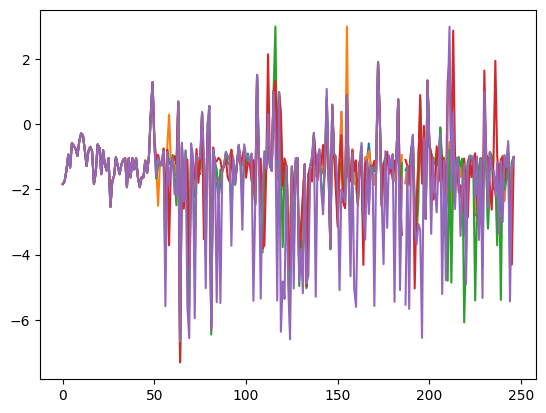

In [8]:
# [plt.plot(np.log10(res[0,:])) for res in results]
[plt.plot(np.log10((res[-1,:]))) for res in results.values()]

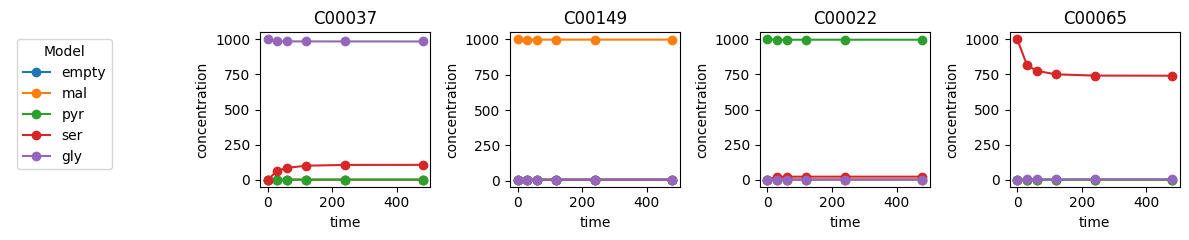

In [10]:
all_results = {s:np.zeros(measurements[s].shape) for s in metadata['sample_labels']}
for k,c in enumerate([p.champion_x for p in pops]):
    res_dict = myprob._simulate(myprob._unscale(xs[k,:]))
    all_results = {s:all_results[s] + res_dict[s][:,myprob.cols[s]][myprob.rows[s],:]/len(pops) for s in metadata['sample_labels']}

plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        plt.plot(metadata['timepoints'][s]/60, all_results[s][:,i],'-o')
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model')
plt.gca().axis('off')
plt.tight_layout()

In [80]:
np.argsort(list(results.values())[0][0,:])

array([186,  26, 137,  35,  42,  17,   0,  27,   1,  44,  37,  43,  41,
        28,  21,  31, 193,  46,  18, 246,  68, 102,  47, 138, 200, 111,
        83, 234,  24,   2,  51, 150, 211,  53, 148, 233,  39, 160, 146,
       173,  62, 117,  78, 241, 107, 223, 157, 159, 109,  96, 151, 133,
       110,  54, 176, 149,  84, 121, 214, 164, 163, 135,  82, 185, 178,
       196, 167,   4, 141,  70,  66, 145, 169,  72, 222,  98, 202,  77,
       113, 166, 224, 136, 104, 239, 177,  55, 245, 192,  64,  90, 216,
       242, 208, 103, 226,  86,  79, 153,  93, 143, 229,  71, 227,  99,
       220, 124, 232, 212,  91, 171, 108,  58, 116, 180, 174, 210, 129,
        73, 131, 162,  81, 158, 221, 204, 207,  13,  30, 243, 179, 126,
        76, 140, 114,  75, 120, 205,  97,  61, 100, 219, 132, 130,  85,
       187, 189,  52,  95, 119, 134,  23,  59, 213, 218,  69, 194, 225,
       168,  92, 235, 105, 201, 175, 142,  88, 139, 237, 101,  32, 190,
        87, 209, 182, 115, 228, 184,  57, 203,  65,  89, 197,  7

In [92]:
r.getFloatingSpeciesIds()[137]

'C00006'